In [1]:
## This is being set up to run popeye on HPC
import numpy as np
import ctypes, time, os
import pickle

# Import visualization stuff
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
rootPath = '/System/Volumes/Data/d/DATD/datd/mrVista_pRF/MD/RF1/MD_RF1_vista'
origRoot = '/System/Volumes/Data/d/DATD/datd/pRF_orig/MD/RF1/MD_RF1_vista'

# Load the original data
ss5File = os.path.join(rootPath, 'bar_seq_1_ss5.nii.gz')
ss5_nii = nib.load(ss5File)
ss5 = ss5_nii.get_fdata()
print(ss5.shape)

(128, 128, 128, 201)


(128, 128, 128, 8)


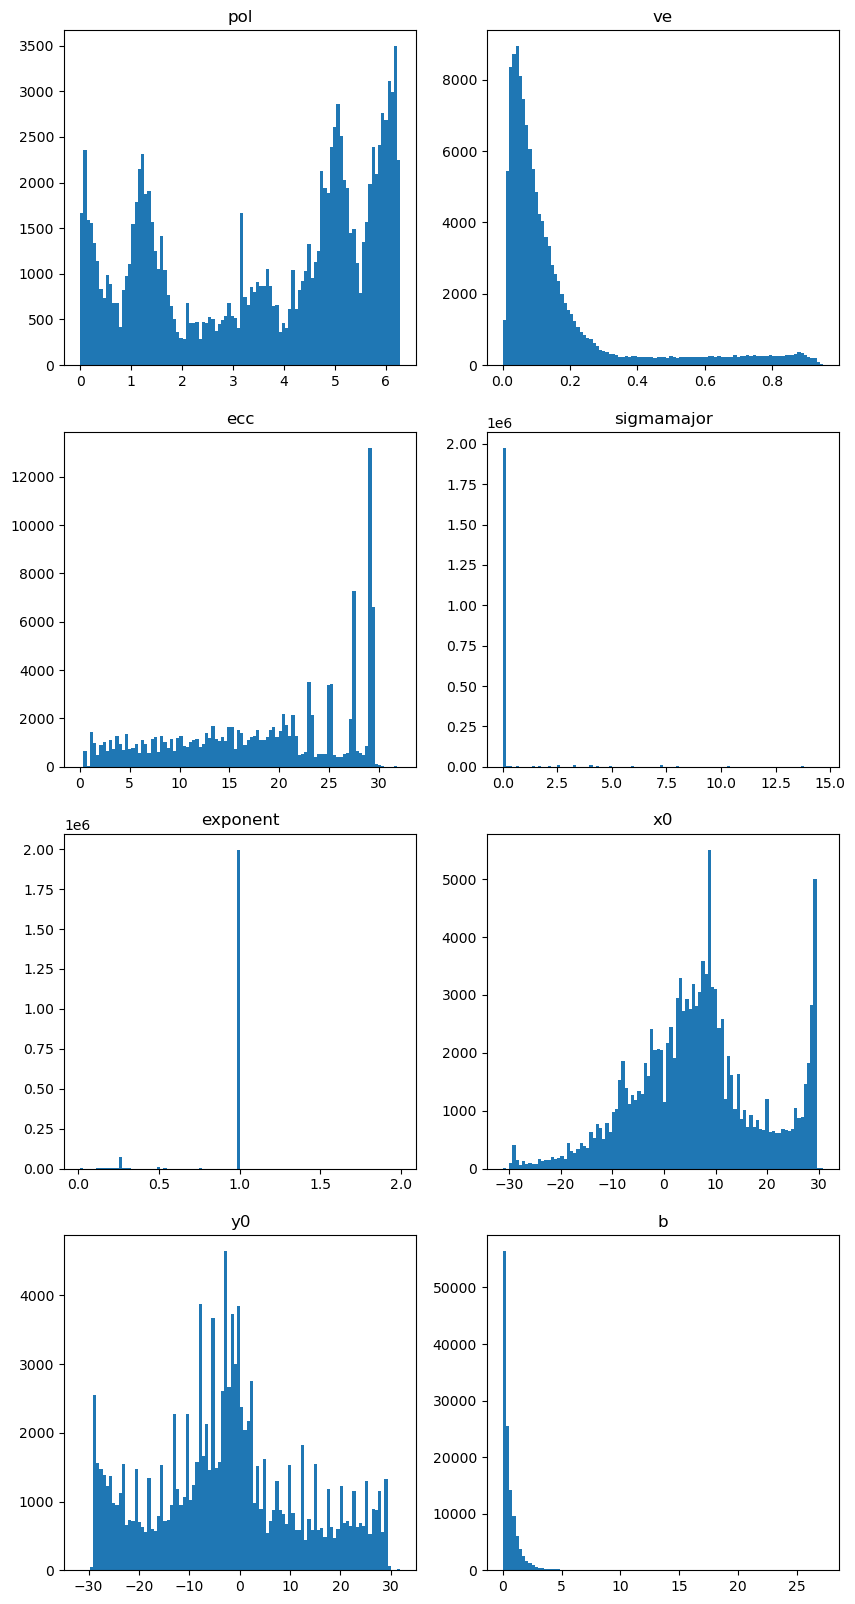

In [3]:
# Load RFestims
rfFile = os.path.join(origRoot, 'Inplane', 'Original', 'RF_ss5-fFit.nii.gz')
rf = nib.load(rfFile).get_fdata()
print(rf.shape)

# pol ve ecc sigmamajor exponent x0 y0 b 
rftitles = ['pol', 've', 'ecc', 'sigmamajor', 'exponent', 'x0', 'y0', 'b']
f, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.ravel()
for i in range(8):
    th = rf[:,:,:,i].flatten()
    th[th == 0] = np.nan
    axs[i].hist(th, bins=100)
    axs[i].set_title(rftitles[i])

plt.show()

In [4]:
# Read simulated Voxels
simRoot = '/System/Volumes/Data/d/DATD/datd/popeye_pRF/Simulation'
simFile = os.path.join(simRoot, 'simulatedVoxels.pkl')
with open(simFile, 'rb') as f:
    simVoxels = pickle.load(f)

nVoxels = len(simVoxels)
print(simVoxels.shape)

# Take the ss5 and replace the values with the simulated values in the same order
# ss5 is of shape 128 * 128 * 128 * nTRs
# simVoxels is a list of nVoxels, each with nTRs
nTRs = ss5.shape[-1]
simData = np.zeros((128, 128, 128, nTRs))

valIndex = 0
for i in range(128):
    for j in range(128):
        for k in range(128):
            if valIndex < nVoxels:
                simData[i, j, k, :] = simVoxels[valIndex]
                valIndex += 1

saveFname = os.path.join(rootPath, 'bar_seq_1_ss5_copy.nii.gz')
simNii = nib.Nifti1Image(simData, ss5_nii.affine, ss5_nii.header)
nib.save(simNii, saveFname)

(10000, 201)


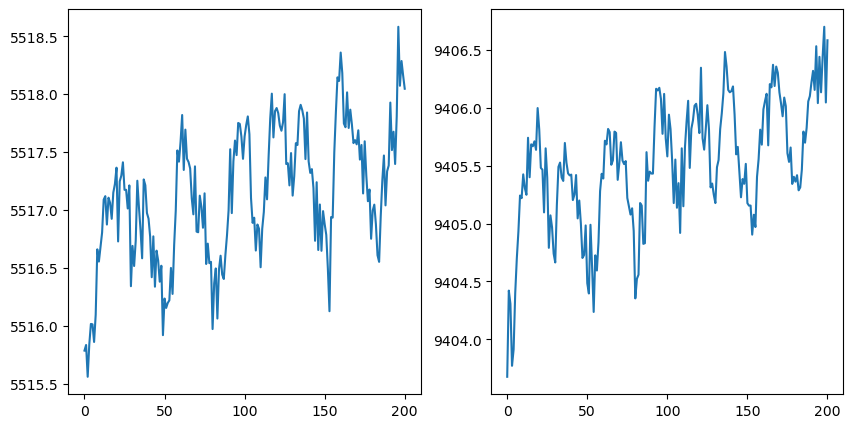

In [22]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
idx = 9999
axs[0].plot(simVoxels[idx])

axs[1].plot(simData[0, 77, 15, :])

plt.show()

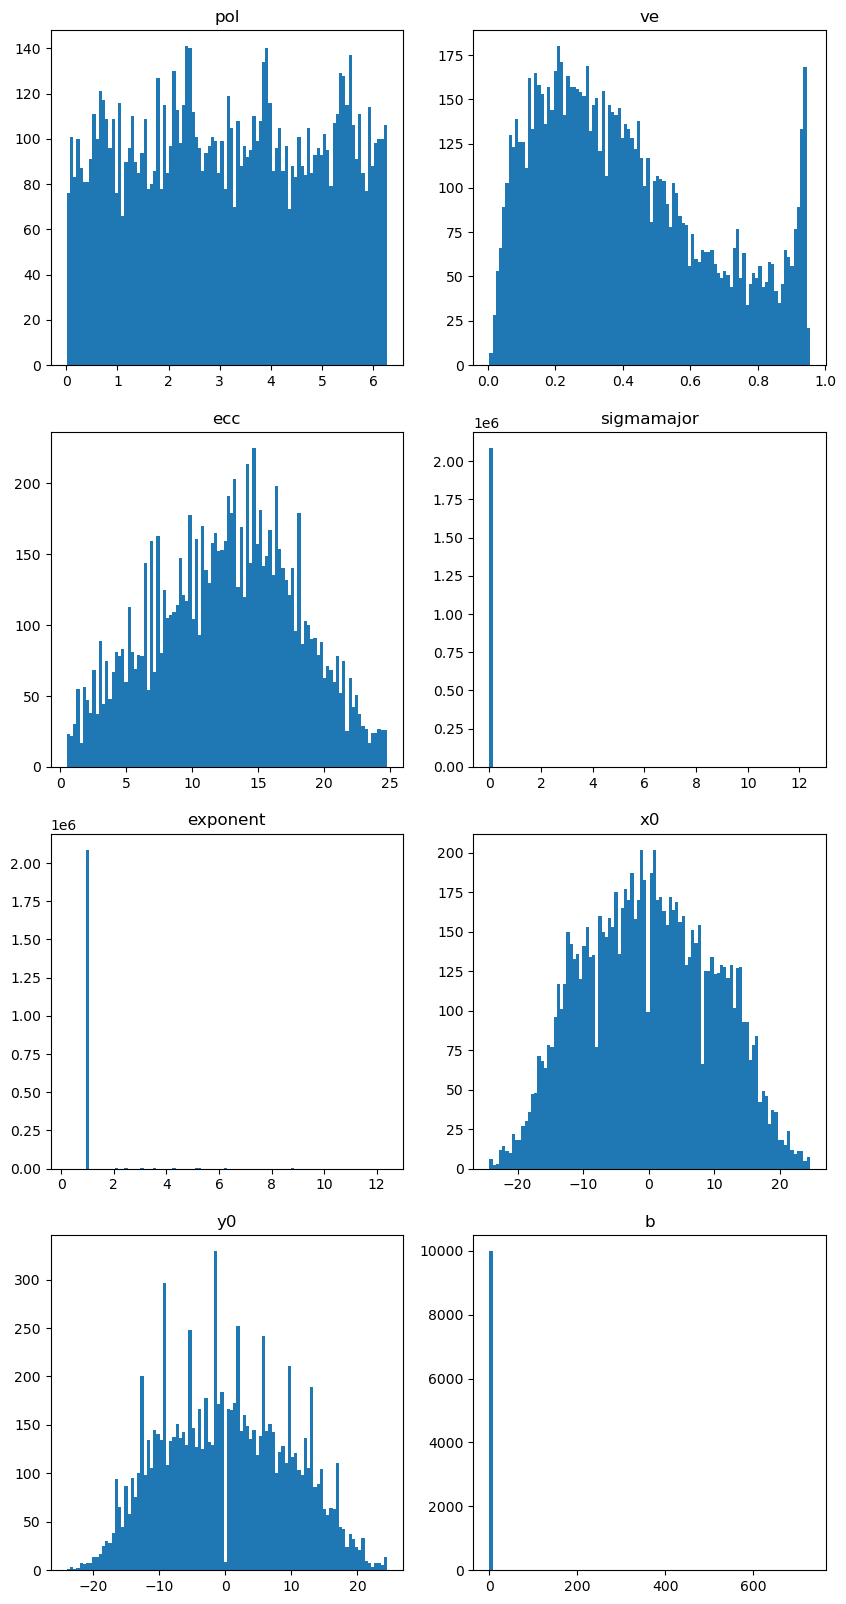

In [24]:
simFitPath = os.path.join(rootPath, 'Inplane', 'Original', 'RF_ss5_copy-fFit.nii.gz')
simFitNii = nib.load(simFitPath)
simFit = simFitNii.get_fdata()


f, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.ravel()
for i in range(8):
    th = simFit[:,:,:,i].flatten()
    th[th == 0] = np.nan
    axs[i].hist(th, bins=100)
    axs[i].set_title(rftitles[i])

plt.show()


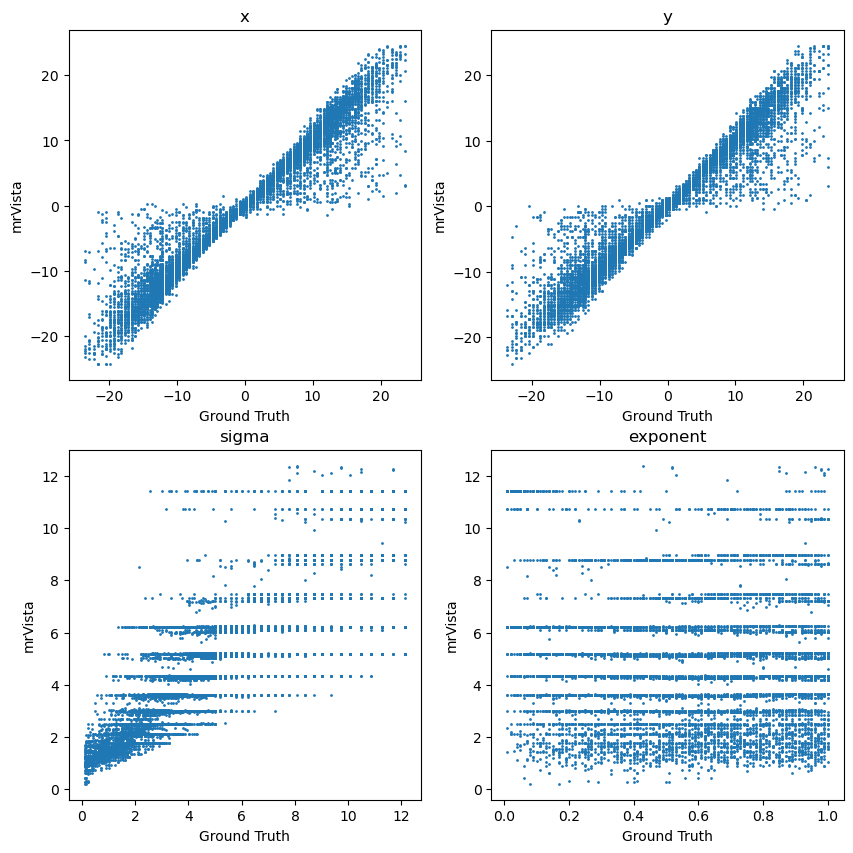

In [25]:
# load ground truth
groundTruthFile = os.path.join(simRoot, 'simulatedParams.pkl')
with open(groundTruthFile, 'rb') as f:
    groundTruth = pickle.load(f)

xTrue, yTrue, sTrue, nTrue = [], [], [], []
for i in range(len(groundTruth['params_vox'])):
    xTrue.append(groundTruth['params_vox'][i][0])
    yTrue.append(groundTruth['params_vox'][i][1])
    sTrue.append(groundTruth['params_vox'][i][2])
    nTrue.append(groundTruth['params_vox'][i][3])

xmrVista, ymrVista, smrVista, nmrVista = np.zeros(nVoxels), np.zeros(nVoxels), np.zeros(nVoxels), np.zeros(nVoxels)
valIndex = 0
for i in range(128):
    for j in range(128):
        for k in range(128):
            if valIndex < nVoxels:
                xmrVista[valIndex] = simFit[i, j, k, 5]
                ymrVista[valIndex] = simFit[i, j, k, 6]
                smrVista[valIndex] = simFit[i, j, k, 3]
                nmrVista[valIndex] = simFit[i, j, k, 4]
                valIndex += 1

# Plot mrVista vs groundTruth
# pol ve ecc sigmamajor exponent x0 y0 b 
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()
axs[0].scatter(xTrue, xmrVista, s=1)
axs[0].set_title('x')
axs[0].set_xlabel('Ground Truth')
axs[0].set_ylabel('mrVista')

axs[1].scatter(yTrue, ymrVista, s=1)
axs[1].set_title('y')
axs[1].set_xlabel('Ground Truth')
axs[1].set_ylabel('mrVista')

axs[2].scatter(sTrue, smrVista, s=1)
axs[2].set_title('sigma')
axs[2].set_xlabel('Ground Truth')
axs[2].set_ylabel('mrVista')

axs[3].scatter(nTrue, nmrVista, s=1)
axs[3].set_title('exponent')
axs[3].set_xlabel('Ground Truth')
axs[3].set_ylabel('mrVista')

plt.show()


In [ ]:
simFit[:,:,:,5].flatten()